In [91]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import tensorflow as tf

In [98]:
PATH_IMG="../../Datas/Grape/"
PATH_TRAIN="../../Datas/data/train/"
PATH_TEST="../../Datas/data/test/"
PATH_VAL="../../Datas/data/val/"

BATCH_SIZE = 64
IMG_SIZE = (160, 160)
EPOCHS = 5
INIT_LR =1e-4

In [ ]:
def generate_new_train_images(folder, to_augment_class, final_number_images, image_size=(160, 160)):
    directory = os.path.join(folder, to_augment_class)

    count = len(os.listdir(directory))

    # Create a data generator for the images with transformations
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Calculate the number of additional images needed to balance the dataset
    augmentation_factor = int(np.ceil(final_number_images / count))
    additional_normal_count = augmentation_factor * count - count

    # Generate additional images and save them to the corresponding subfolder
    normal_generator = datagen.flow_from_directory(
        folder,
        batch_size=1,
        target_size=image_size,
        save_to_dir=directory,
        save_format='jpeg',
        save_prefix='augmented_',
        classes=[to_augment_class]
    )

    for i in range(additional_normal_count):
        normal_generator.next()

    # Check the number of images in subfolder
    new_count = len(os.listdir(directory))
    print(f'New {to_augment_class} count: {new_count}')


In [93]:
# For each subfolder in the PATH_TRAIN folder, generate new images
for subfolder in os.listdir(PATH_TRAIN):
    if os.path.isdir(os.path.join(PATH_TRAIN, subfolder)):
        generate_new_train_images(PATH_TRAIN, subfolder, 1000, image_size=IMG_SIZE)


val_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=PATH,
                                             shuffle=True,
                                             target_size=IMG_SIZE,
                                             subset="validation",
                                             class_mode='categorical')

Found 4624 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


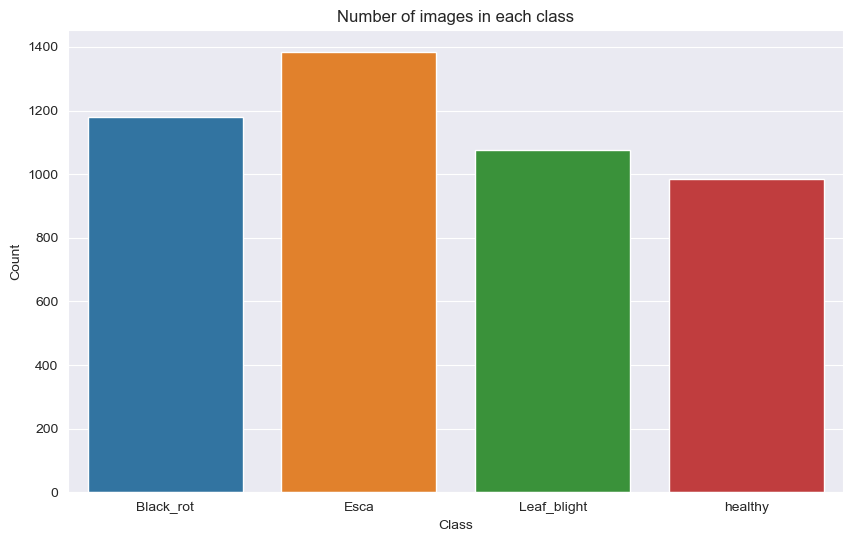

In [94]:
# Get class labels
class_labels = list(train_ds.class_indices.keys())

# Get number of images in each class
class_counts = np.bincount(train_ds.labels)

# Create a DataFrame with class labels and counts
class_counts_df = pd.DataFrame({
    'Class': class_labels,
    'Count': class_counts
})

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts_df, x='Class', y='Count')
plt.title('Number of images in each class')
plt.show()

In [95]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [96]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) # R,G,B Channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [97]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

ResourceExhaustedError: Exception encountered when calling layer "block_1_pad" "                 f"(type ZeroPadding2D).

{{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[64,81,81,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pad]

Call arguments received by layer "block_1_pad" "                 f"(type ZeroPadding2D):
  • inputs=tf.Tensor(shape=(64, 80, 80, 96), dtype=float32)

In [ ]:
# Add a global spatial average pooling layer
out = base_model.output
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
predictions = tf.keras.layers.Dense(4, activation='softmax')(out)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers and use theyas feature extractor trained ln imagenet
for layer in base_model.layers:
    layer.trainable = False

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
fine_tune_epochs = 5
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
final_loss, final_accuracy = model.evaluate(val_ds)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}".format(final_accuracy))